In [1]:
from autotst.molecule import *
from autotst.reaction import *
from autotst.database import *
from autotst.geometry import *

# To view ase atoms
from ase.visualize import view
import py3Dmol


thermo.py:836 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:836 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:836 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:853 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-database/input/transport/groups...
database.py:167 loadFamilies INFO Loading the user-specified kinetics families from /Users/nathan/Code/RMG-database/input/kinetics/families
statmech.py:526 loadGroups INFO Loading frequencies group database from /Users/nathan/Code/RMG-database/input/statmech/groups...
database.py:127 l

# Just a quick way to observe molecules

In [2]:
mol = AutoTST_Molecule("CCCC")
mol

<autotst.molecule.AutoTST_Molecule instance at 0x11b5d4998>

In [3]:
mol.rmg_molecule.atoms[0].coords

array([-0.4262,  0.4325, -0.6026])

In [4]:
view(mol.ase_molecule, viewer='x3d')

# In order to do this, you need to have pip installed py3dmol
mol.view_mol()

## So, now we're going to demonstrate how this works on a step by step process

In [5]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.rdMolTransforms import *
import ase
from ase import Atom, Atoms
import rmgpy
from rmgpy.molecule import Molecule
import py3Dmol
import numpy as np

In [6]:
smiles = "CCCC"
rmg_mol = Molecule(SMILES=smiles)
rmg_mol

In [7]:
def view_mol(mol):
    """
    A method designed to create a 3D figure of the AutoTST_Molecule with py3Dmol from the rdkit_molecule
    """
    mb  = Chem.MolToMolBlock(mol)
    p = py3Dmol.view(width=400, height=400)
    p.addModel(mb, "sdf")
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

In [8]:
rdkit_mol = rmg_mol.toRDKitMol(removeHs=False)
rdkit.Chem.AllChem.EmbedMolecule(rdkit_mol)
#view_mol(rdkit_mol)

0

In [9]:
mol_list = AllChem.MolToMolBlock(rdkit_mol).split('\n')
ase_atoms = []
for i, line in enumerate(mol_list):

    if i > 3:
        try:
            atom0, atom1, bond, rest = line
            atom0 = int(atom0)
            atom0 = int(atom1)
            bond = float(bond)

        except ValueError:
            try:
                x, y, z, symbol = line.split()[0:4]
                x = float(x)
                y = float(y)
                z = float(z)
                #print symbol

                ase_atoms.append(Atom(symbol=symbol, position=(x,y,z)))
            except:
                continue

ase_mol = Atoms(ase_atoms)
view(ase_mol, viewer='x3d')

### So, in it's simplicity, an `AutoTST_Molecule` is an object that houses all of the above information (with additional geometric features)

# Now for reactions

Reactions have to be `RMG_Reactions` or in the form `r1+r2_p1+p2`. Currently this is only set up for H_Abstractions, but others should be able to work later

In [10]:
Molecule(SMILES="C")

In [11]:
mol = AutoTST_Molecule("CCC")
mol.ase_molecule

Atoms(symbols='C3H8', pbc=False)

In [42]:
rxn = AutoTST_Reaction("CCC+[O]O_[CH2]CC+OO", "H_Abstraction")
rxn

reaction.py:424 bm_pre_edit INFO Changing lower limit 2.9 to 2.393074
reaction.py:424 bm_pre_edit INFO Changing lower limit 3.65 to 3.26214059416
reaction.py:424 bm_pre_edit INFO Changing lower limit 2.520343 to 2.457475


<autotst.reaction.AutoTST_Reaction instance at 0x122bd9dd0>

In [45]:
rxn.rmg_reaction

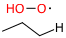

In [46]:
rxn.ts.rmg_ts

In [47]:
view(rxn.ts.ase_ts, viewer='x3d')

In [48]:
import os
import logging
FORMAT = "%(filename)s:%(lineno)d %(funcName)s %(levelname)s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import rdkit, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit.Chem.rdMolTransforms import *
from rdkit.Chem.rdChemReactions import ChemicalReaction
from rdkit.Chem import AllChem

from rdkit.Chem.Pharm3D import EmbedLib

import py3Dmol

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction, _isomorphicSpeciesList
from rmgpy.kinetics import PDepArrhenius, PDepKineticsModel
from rmgpy.data.rmg import RMGDatabase

# AutoTST imports
from autotst.database import DistanceData, TransitionStateDepository, TSGroups, TransitionStates
from autotst.molecule import *
from autotst.geometry import *


In [49]:
reaction_string = "CCC+[O]O_[CH2]CC+OO"
family_string = "H_Abstraction"

In [50]:
reactants, products = reaction_string.split("_")

if "+" in reactants:
    reactants = reactants.split("+")

if "+" in products:
    products = products.split("+")

reactant_mols = []
product_mols = []

for reactant in reactants:
    reactant_mols.append(AutoTST_Molecule(reactant))

for product in products:
    product_mols.append(AutoTST_Molecule(product))

reactant_mols, product_mols

([<autotst.molecule.AutoTST_Molecule instance at 0x122bc94d0>,
  <autotst.molecule.AutoTST_Molecule instance at 0x11fe621b8>],
 [<autotst.molecule.AutoTST_Molecule instance at 0x122bc9ab8>,
  <autotst.molecule.AutoTST_Molecule instance at 0x122d55248>])

In [51]:
rmg_database = RMGDatabase()
database_path = os.path.join(os.path.expanduser('~'), 'Code',  'RMG-database', 'input')
rmg_database.load(database_path,
                 kineticsFamilies=['H_Abstraction'],
                 transportLibraries=[],
                 reactionLibraries=[],
                 seedMechanisms=[],
                 thermoLibraries=['primaryThermoLibrary', 'thermo_DFT_CCSDTF12_BAC', 'CBS_QB3_1dHR' ],
                 solvation=False,
                 )

family = rmg_database.kinetics.families["H_Abstraction"]
family

rmg.py:72 __init__ WARNING Should only make one instance of RMGDatabase because it's stored as a module-level variable!
rmg.py:73 __init__ WARNING Unexpected behaviour may result!
thermo.py:836 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:836 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:836 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:853 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-database/input/thermo/groups...
transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-database/input/transport/groups...
database.py:167 loadFamilies INFO Loading the user-specified kinetics families from /Users/nathan/Code/RMG

<ReactionFamily "H_Abstraction">

### This chunk gets the labeled reactants and products

In [52]:
ts_database = TransitionStates()
path = "../database/H_Abstraction"
global_context = { '__builtins__': None }
local_context={'DistanceData': DistanceData}
family = rmg_database.kinetics.families["H_Abstraction"]
ts_database.family = family
ts_database.load(path, local_context, global_context)

database.py:127 load INFO Loading transitions state family groups from ../database/H_Abstraction/TS_groups.py


In [53]:
ts_database

<autotst.database.TransitionStates instance at 0x11d291878>

In [59]:
type(test_reaction)

rmgpy.reaction.Reaction

In [57]:
for reaction in reaction_list:
    if reaction.isIsomorphic(test_reaction):
        break
        
reaction

In [23]:
rmg_reactants = []
rmg_products = []

for reactant_mol in reactant_mols:
    rmg_reactants.append(reactant_mol.rmg_molecule)

for product_mol in product_mols:
    rmg_products.append(product_mol.rmg_molecule)
    
    
labeled_r, labeled_p = family.getLabeledReactantsAndProducts(rmg_reactants, rmg_products)
test_reaction = Reaction(reactants=labeled_r, products=labeled_p, reversible=True)
test_reaction

### This chunk makes a template reaction with the `H_Abstraction` family attached

In [55]:
reaction_list = rmg_database.kinetics.generate_reactions_from_families(
            rmg_reactants,
            rmg_products)

assert reaction_list

for rmg_reaction in reaction_list:
    if rmg_reaction.isIsomorphic(test_reaction):
        if (_isomorphicSpeciesList(rmg_reaction.reactants, test_reaction.reactants)) and (_isomorphicSpeciesList(rmg_reaction.products, test_reaction.products)):
            rmg_reaction.reactants = test_reaction.reactants
            rmg_reaction.products = test_reaction.products

        elif (_isomorphicSpeciesList(rmg_reaction.products, test_reaction.reactants)) and (_isomorphicSpeciesList(rmg_reaction.reactants, test_reaction.products)):
            rmg_reaction.products = test_reaction.reactants
            rmg_reaction.reactants = test_reaction.products
            
        
            
print rmg_reaction.family
rmg_reaction

H_Abstraction


In [25]:
type(rmg_reaction)

rmgpy.data.kinetics.family.TemplateReaction

In [60]:
distance_data = ts_database.groups.estimateDistancesUsingGroupAdditivity(reaction)
distance_data

DistanceData(distances={'d12': 1.380401,'d13': 2.530343,'d23': 1.157074,}, uncertainties={'d12': 0.385038,'d13': 0.208449,'d23': 0.303191,}, comment=u'Matched node C/H3/Cs ([<Entry index=118 label="C/H3/Cs">, <Entry index=262 label="Cdj_CdsCs">])\nMatched node OjO ([<Entry index=126 label="C/H2/Cd/Cd">, <Entry index=32 label="OjO">])\n')

### Once we have all of this info, we can now make the 3D geometry using RDKit

#### First, we merge the reactant and product geometries

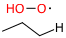

In [61]:
merged_reacts = None
merged_prods = None

if len(rmg_reaction.reactants) == 2:
    merged_reacts = Molecule.merge(rmg_reaction.reactants[0],
                                   rmg_reaction.reactants[1])

if len(rmg_reaction.products) == 2:
    merged_prods = Molecule.merge(rmg_reaction.products[0],
                                   rmg_reaction.products[1])
    
merged_reacts.updateMultiplicity()
merged_reacts

In [62]:
for i, atom in enumerate(merged_reacts.atoms):
    if atom.label == "*1":
        lbl1 = i
    if atom.label == "*2":
        lbl2 = i
    if atom.label == "*3":
        lbl3 = i
labels = [lbl1, lbl2, lbl3]
atomMatch = ((lbl1,), (lbl2,), (lbl3,))
labels

[1, 5, 12]

### Now we actually make the RDKit Geometry

In [63]:
combined = merged_reacts.toRDKitMol(removeHs=False)
Chem.rdDistGeom.EmbedMolecule(combined)
view_mol(combined)

In [64]:
bm = rdkit.Chem.rdDistGeom.GetMoleculeBoundsMatrix(combined)
bm

array([[  0.00000000e+00,   1.52400000e+00,   1.52400000e+00,
          1.11940079e+00,   1.11940079e+00,   2.19506659e+00,
          2.19506659e+00,   2.19506659e+00,   2.19506659e+00,
          2.19506659e+00,   2.19506659e+00,   1.00000000e+03,
          1.00000000e+03,   1.00000000e+03],
       [  1.50400000e+00,   0.00000000e+00,   2.51279063e+00,
          2.19506659e+00,   2.19506659e+00,   1.11940079e+00,
          1.11940079e+00,   1.11940079e+00,   3.43890609e+00,
          3.43890609e+00,   3.43890609e+00,   1.00000000e+03,
          1.00000000e+03,   1.00000000e+03],
       [  1.50400000e+00,   2.43279063e+00,   0.00000000e+00,
          2.19506659e+00,   2.19506659e+00,   3.43890609e+00,
          3.43890609e+00,   3.43890609e+00,   1.11940079e+00,
          1.11940079e+00,   1.11940079e+00,   1.00000000e+03,
          1.00000000e+03,   1.00000000e+03],
       [  1.09940079e+00,   2.11506659e+00,   2.11506659e+00,
          0.00000000e+00,   1.85196558e+00,   3.07538100e+0

In [65]:
def set_limits( bm, lbl1, lbl2, value, uncertainty):
    """
    A method to set the limits of a particular distance between two atoms

    :param bm: an array of arrays corresponding to the bounds matrix
    :param lbl1: the label of one atom
    :param lbl2: the label of another atom
    :param value: the distance from a distance data object (float)
    :param uncertainty: the uncertainty of the `value` distance (float)
    :return bm: an array of arrays corresponding to the edited bounds matrix
    """
    if lbl1 > lbl2:
        bm[lbl2][lbl1] = value + uncertainty / 2
        bm[lbl1][lbl2] = max(0, value - uncertainty / 2)
    else:
        bm[lbl2][lbl1] = max(0, value - uncertainty / 2)
        bm[lbl1][lbl2] = value + uncertainty / 2

    return bm

In [66]:
lbl1, lbl2, lbl3 = labels

sect = [] #rename for future
for atom in merged_reacts.split()[1].atoms: sect.append(atom.sortingLabel)

uncertainties = {'d12': 0.02, 'd13': 0.02, 'd23': 0.02}  # distanceData.uncertainties or {'d12':0.1, 'd13':0.1, 'd23':0.1 } # default if uncertainty is None
bm = set_limits(bm, lbl1, lbl2, distance_data.distances['d12'], uncertainties['d12'])
bm = set_limits(bm, lbl2, lbl3, distance_data.distances['d23'], uncertainties['d23'])
bm = set_limits(bm, lbl1, lbl3, distance_data.distances['d13'], uncertainties['d13'])
bm

array([[  0.00000000e+00,   1.52400000e+00,   1.52400000e+00,
          1.11940079e+00,   1.11940079e+00,   2.19506659e+00,
          2.19506659e+00,   2.19506659e+00,   2.19506659e+00,
          2.19506659e+00,   2.19506659e+00,   1.00000000e+03,
          1.00000000e+03,   1.00000000e+03],
       [  1.50400000e+00,   0.00000000e+00,   2.51279063e+00,
          2.19506659e+00,   2.19506659e+00,   1.39040100e+00,
          1.11940079e+00,   1.11940079e+00,   3.43890609e+00,
          3.43890609e+00,   3.43890609e+00,   1.00000000e+03,
          2.54034300e+00,   1.00000000e+03],
       [  1.50400000e+00,   2.43279063e+00,   0.00000000e+00,
          2.19506659e+00,   2.19506659e+00,   3.43890609e+00,
          3.43890609e+00,   3.43890609e+00,   1.11940079e+00,
          1.11940079e+00,   1.11940079e+00,   1.00000000e+03,
          1.00000000e+03,   1.00000000e+03],
       [  1.09940079e+00,   2.11506659e+00,   2.11506659e+00,
          0.00000000e+00,   1.85196558e+00,   3.07538100e+0

In [67]:
others = range(len(bm))
for idx in sect: others.remove(idx)

for i in range(len(bm)):#sect:
    for j in range(i):#others:
        if i<j: continue
        for k in range(len(bm)):
            if k==i or k==j or i==j: continue
            Uik = bm[i,k] if k>i else bm[k,i]
            Ukj = bm[j,k] if k>j else bm[k,j]

            maxLij = Uik + Ukj - 0.1
            if bm[i,j] >  maxLij:
                logging.info("Changing lower limit {0} to {1}".format(bm[i, j], maxLij))
                bm[i,j] = maxLij


<ipython-input-67-0083f93e28d9>:14 <module> INFO Changing lower limit 2.9 to 2.393074
<ipython-input-67-0083f93e28d9>:14 <module> INFO Changing lower limit 3.65 to 3.26214059416
<ipython-input-67-0083f93e28d9>:14 <module> INFO Changing lower limit 2.520343 to 2.457475


In [68]:
rdkit.DistanceGeometry.DoTriangleSmoothing(bm)
# Triangle smoothing is??

True

In [69]:
bm

array([[ 0.        ,  1.524     ,  1.524     ,  1.11940079,  1.11940079,
         2.19506659,  2.19506659,  2.19506659,  2.19506659,  2.19506659,
         2.19506659,  4.68814059,  3.36214059,  5.29488373],
       [ 1.504     ,  0.        ,  2.51279063,  2.19506659,  2.19506659,
         1.390401  ,  1.11940079,  1.11940079,  3.43890609,  3.43890609,
         3.43890609,  3.866343  ,  2.540343  ,  4.47308614],
       [ 1.504     ,  2.43279063,  0.        ,  2.19506659,  2.19506659,
         3.43890609,  3.43890609,  3.43890609,  1.11940079,  1.11940079,
         1.11940079,  5.93198009,  4.60598009,  6.53872323],
       [ 1.09940079,  2.11506659,  2.11506659,  0.        ,  1.85196558,
         3.075381  ,  3.075381  ,  3.075381  ,  3.075381  ,  3.075381  ,
         3.075381  ,  5.568455  ,  4.242455  ,  6.17519814],
       [ 1.09940079,  2.11506659,  2.11506659,  1.77196558,  0.        ,
         3.075381  ,  3.075381  ,  3.075381  ,  3.075381  ,  3.075381  ,
         3.075381  ,  5.56

In [70]:
combined.RemoveAllConformers()
for i in range(0, 1000):
    try:
        EmbedLib.EmbedMol(combined, bm, atomMatch=atomMatch)
        break
    except ValueError:
        x = 3
        logging.info("RDKit failed to embed on attempt {0} of {1}".format(i + 1, 1000))
        # What to do next (what if they all fail?) !!!!!
    except RuntimeError:
        logging.info("RDKit failed to embed.")
else:
    logging.error("RDKit failed all attempts to embed")
    
for i in range(len(combined.GetConformers())):
    combined.GetConformers()[i].SetId(i)
    
view_mol(combined)

In [71]:
energy = 0.0
minEid = 0;
lowestE = 9.999999e99;  # start with a very high number, which would never be reached
crude = Chem.Mol(combined.ToBinary())

for conf in combined.GetConformers():
    if bm is None:
        AllChem.UFFOptimizeMolecule(combined, confId=conf.GetId())
        energy = AllChem.UFFGetMoleculeForceField(combined, confId=conf.GetId()).CalcEnergy()
    else:
        eBefore, energy = EmbedLib.OptimizeMol(combined, bm, atomMatches=atomMatch,
                                               forceConstant=100000.0)

    if energy < lowestE:
        minEid = conf.GetId()
        lowestE = energy
        
view_mol(combined)

In [72]:
mol_list = AllChem.MolToMolBlock(combined).split('\n')
ase_atoms = []
for i, line in enumerate(mol_list):

    if i > 3:

        try:
            atom0, atom1, bond, rest = line
            atom0 = int(atom0)
            atom0 = int(atom1)
            bond = float(bond)

        except ValueError:
            try:
                x, y, z, symbol = line.split()[0:4]
                x = float(x)
                y = float(y)
                z = float(z)
                # print symbol

                ase_atoms.append(Atom(symbol=symbol, position=(x, y, z)))

            except:
                continue

ase_ts = Atoms(ase_atoms)
view(ase_ts, viewer='x3d')

# Now to show how to use calculators!

In [73]:
from ase.calculators.gaussian import *

calc = Gaussian(mem="5GB", 
                nprocshared="20", 
                label="test", 
                scratch="/gss_gpfs_scratch/harms.n/drug_conformer", 
                method="m062x", 
                basis="6-311+g(2df,2p)",
                extra="opt=(ts,calcfc,noeigentest) freq",
                multiplicity = merged_reacts.multiplicity)
del calc.parameters['force']
calc.parameters

{'basis': '6-311+g(2df,2p)',
 'charge': 0,
 'mem': '5GB',
 'method': 'm062x',
 'multiplicity': 2,
 'nprocshared': '20'}

In [74]:
calc.write_input(ase_ts)

In [41]:
calc.calculate(ase_ts)

RuntimeError: Gaussian in . returned an error: 127